
# Explore DCE-MRI in experimental rat tumor  (work in progress ...)

BMED360-2021  `02-dce-mri-rat-brain-tumor-explore.ipynb`

<a href="https://colab.research.google.com/github/computational-medicine/BMED360-2021/blob/main/Lab5-DCE-MRI/02-dce-mri-rat-brain-tumor-explore.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
colab = False

## Learning objectives

- Define vessel permeability and leakage as a (patho)physiological process assessed in vivi using DCE-MRI [[Lec6](https://docs.google.com/presentation/d/1EYuKHtQM4RIgkvIxrMyAkq02l8KUd9WuCsjCHviBaKI/edit#slide=id.g5924ccd5d0_0_0)]
- Describe the principles of pharmacokinetic modelling using compartment models and tracer kinetics assuming conservation of mass
- Provide an example with real data (experimental rat brain tumor implant)

## Setup

In [2]:
# Set this to True if you are using Colab:
# colab = True

### For Google Colab

In [3]:
if colab == True:
    !pip install gdown
    !pip install nilearn
    !pip install sklearn

### Setup libraries and folders 

In [4]:
%matplotlib inline
import os
from os.path import expanduser, join, basename, split
import pathlib
import glob
import shutil
import platform
import gdown
import numpy as np
import scipy.io as spio
import pandas as pd
import nibabel as nib
import nilearn
import imageio
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import skimage

In [5]:
cwd = os.getcwd()
data_dir = join(cwd, 'data')
assets_dir = join(cwd, 'assets')
fn = f'{data_dir}/ng2_1and2_7_2_multispectral.mat'

**Check your platform**

In [6]:
if platform.system() == 'Darwin':
    print(f'OK, you are running on MacOS ({platform.version()})')
if platform.system() == 'Linux':
    print(f'OK, you are running on Linux ({platform.version()})')
if platform.system() == 'Windows':
    print(f'OK, but consider to install WSL for Windows10 since you are running on {platform.system()}')
    print('Check https://docs.microsoft.com/en-us/windows/wsl/install-win10')

OK, you are running on MacOS (Darwin Kernel Version 20.4.0: Fri Mar  5 01:14:14 PST 2021; root:xnu-7195.101.1~3/RELEASE_X86_64)


### Download data from Google Drive using gdown** (https://github.com/wkentaro/gdown)

In [7]:
# Download zip-file if ./assets does not exist (as when running in Colab)

if os.path.isdir(assets_dir) == False:
    
    ## Download assets.zip for Google Drive             
    # https://drive.google.com/file/d/1fM6fIG9fuxX28_pQtrZZLyRxZZTF01tG/view?usp=sharing
    file_id = '1fM6fIG9fuxX28_pQtrZZLyRxZZTF01tG'
    url = 'https://drive.google.com/uc?id=%s' % file_id
    output = './assets.zip'
    gdown.download(url, output, quiet=False)
    
    ## Unzip the assets file into `./assets`
    shutil.unpack_archive(output, '.')
    
    ## Delete the `assets.zip` file
    os.remove(output)
else:
    print(f'./assets  exists already!')

./assets  exists already!


In [8]:
# Download zip-file if ./data does not exist (as when running in Colab)

if os.path.isdir(data_dir) == False:
    
    ## Download data.zip for Google Drive                
    # https://drive.google.com/file/d/13e8EqQF9xgdRdCCi-bB_BaYrkUCVs0sX/view?usp=sharing
    file_id = '13e8EqQF9xgdRdCCi-bB_BaYrkUCVs0sX'
    url = 'https://drive.google.com/uc?id=%s' % file_id
    output = './data.zip'
    gdown.download(url, output, quiet=False)
    
    ## Unzip the assets file into `./data`
    shutil.unpack_archive(output, '.')
    
    ## Delete the `data.zip` file
    os.remove(output)
else:
    print(f'./data  exists already!')

./data  exists already!


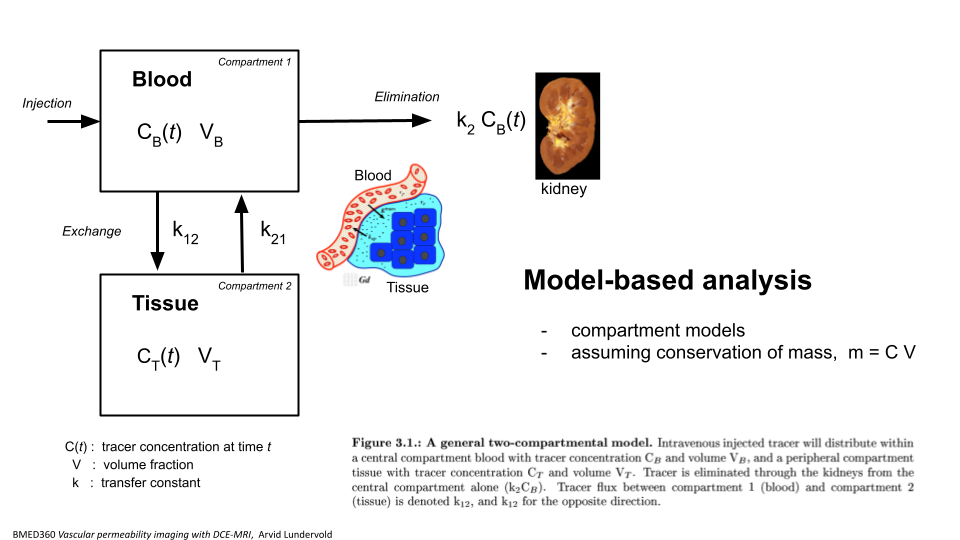

In [9]:
from IPython.display import Image
Image('./assets/BMED_360_Lec6_vascular_permeability_dce_mri_model_based_analysis.png', width=800)

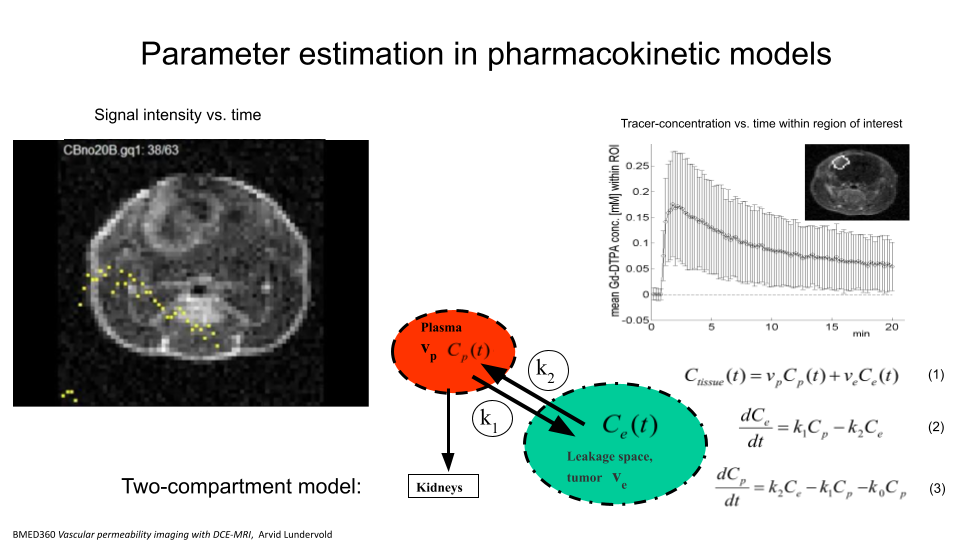

In [10]:
from IPython.display import Image
Image('./assets/BMED_360_Lec6_vascular_permeability_dce_mri_pharmacokinetic_model.png', width=800)

## Read the 4D DCE-MRI data and more

See: https://stackoverflow.com/questions/7008608/scipy-io-loadmat-nested-structures-i-e-dictionaries

In [11]:
# Using scipy spio to read the rat brain multispectral imaging data as a dictionary
dct = spio.loadmat(fn)

In [12]:
# An array of structs, analyzed with trial and error (and a look to the mat-file using MATLAB)
dct.keys()

dict_keys(['__header__', '__version__', '__globals__', 'r'])

In [13]:
keys = [k[0][:] for i, k in enumerate(dct['r'].dtype.descr)]
keys

['feature', 'X5', 'R5', 'X1', 'X2', 'X3', 'X4', 'rat_id_no', 'exam_no', 'name']

In [14]:
seqs = [dct['r'][0,0]['feature'][0,i]['seq'][0].strip() for i in range(len(['X5', 'X1', 'X2', 'X3', 'X4']))]
seqs

['RARE', 'FLAIR', 'T1_5_1', 'T1_DYN', 'T1_POST']

In [15]:
valsName = dct['r'][0,0]['name']
valsID = dct['r'][0,0]['rat_id_no']
valsNo = dct['r'][0,0]['exam_no']
id = f'{valsName[0][:-4]}_{valsID[0]}_{valsNo[0]}_multispectral'
id

'CBno20B_ng2_1and2_7_2_multispectral'

**DCE-MRI T1 DYN seqeunece**

In [16]:
T1_DYN = dct['r'][0,0]['X4']
print(T1_DYN.shape)

(256, 256, 63)


In [17]:
data1 = T1_DYN.reshape(256,256,1,63)
data1.shape

(256, 256, 1, 63)

In [18]:
# By trial and error vs. Freeview
data = np.fliplr(np.flipud(np.transpose(data1, (1, 0, 2, 3))))

In [19]:
img = nib.Nifti1Image(data, np.eye(4))
nib.save(img, f'./data/{id}_T1_DYN.nii.gz')

**T1-mapping sequence (1-5)**

In [20]:
T1_5_1 = dct['r'][0,0]['X3']
T1_5_1 .shape

(256, 256, 5)

In [21]:
data1 = T1_5_1.reshape(256,256,1,5)
data1.shape

(256, 256, 1, 5)

In [22]:
data = np.fliplr(np.flipud(np.transpose(data1, (1, 0, 2, 3))))

In [23]:
img = nib.Nifti1Image(data, np.eye(4))
nib.save(img, f'./data/{id}_T1_5_1.nii.gz')

**RARE sequence**

In [24]:
RARE = dct['r'][0,0]['X5']
RARE.shape

(256, 256)

In [25]:
data1 = RARE.reshape(256,256)
data1.shape

(256, 256)

In [26]:
data = np.fliplr(np.flipud(np.transpose(data1, (1, 0))))

In [27]:
img = nib.Nifti1Image(data, np.eye(4))
nib.save(img, f'./data/{id}_RARE.nii.gz')

**FLAIR sequence**

In [28]:
FLAIR = dct['r'][0,0]['X1']
FLAIR.shape

(256, 256)

In [29]:
data1 = FLAIR.reshape(256,256)
data1.shape

(256, 256)

In [30]:
data = np.fliplr(np.flipud(np.transpose(data1, (1, 0))))

In [31]:
img = nib.Nifti1Image(data, np.eye(4))
nib.save(img, f'./data/{id}_FLAIR.nii.gz')

### Explore properties of the DCE-MRI NIFTI image

In [32]:
fn = f'./data/{id}_T1_DYN.nii.gz'

In [33]:
img = nib.load(fn)

In [34]:
print('**DSC-MRI data info:**')
print(img.get_filename())
print('shape of image = ', img.header.get_data_shape())
print('units = ', img.header.get_xyzt_units())
print('voxel size = ', img.header.get_zooms())
print('dtype = %s' % img.header.get_data_dtype())
data = img.get_fdata()
print('min = %.1f' % data.min())
print('max = %.1f' % data.max())
print('number of timepoints =', img.shape[-1])
# Collaps the singular (z-)dimension
img_data = np.uint16(data.squeeze())
print('shape of 4D img_data = ',img_data.shape)
print('dtype of 4D img_data = ',img_data.dtype)
print('img affine:', img.affine)
print(img.header)

**DSC-MRI data info:**
./data/CBno20B_ng2_1and2_7_2_multispectral_T1_DYN.nii.gz
shape of image =  (256, 256, 1, 63)
units =  ('unknown', 'unknown')
voxel size =  (1.0, 1.0, 1.0, 1.0)
dtype = float64
min = -1730.3
max = 38245.9
number of timepoints = 63
shape of 4D img_data =  (256, 256, 63)
dtype of 4D img_data =  uint16
img affine: [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  4 256 256   1  63   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float64
bitpix          : 64
slice_start     : 0
pixdim          : [1. 1. 1. 1. 1. 1. 1. 1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max        

**Display selected slice and four different timeframes**

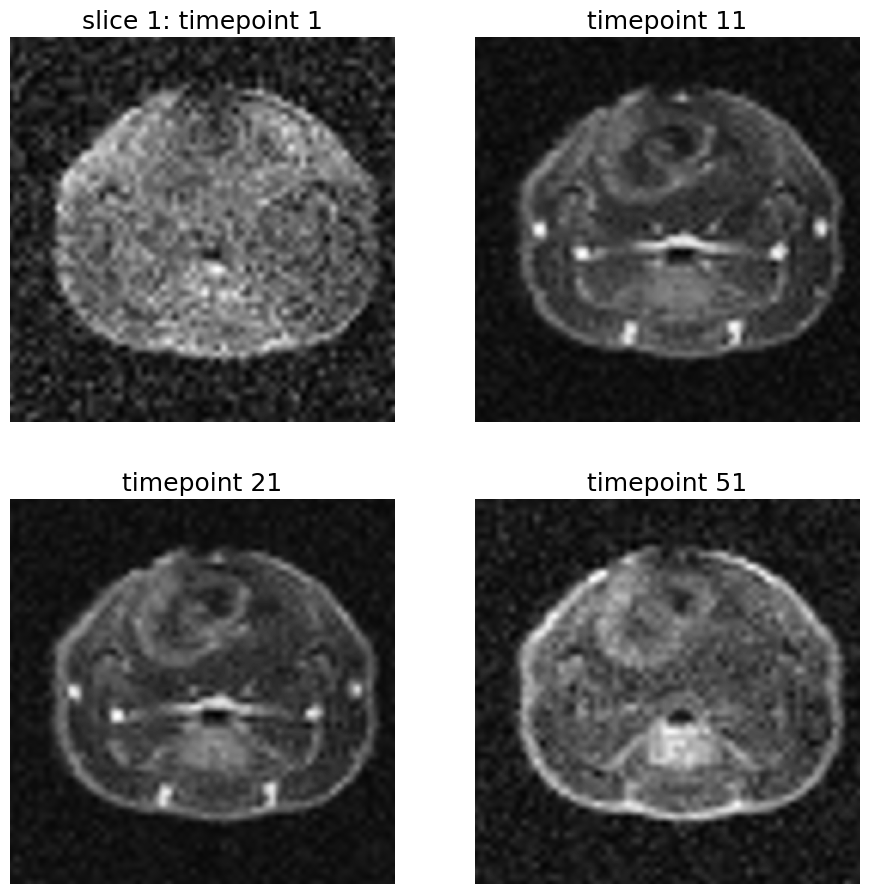

In [35]:
# Arrays starts at 0 (therefors add 1 in the figure)
s = 0
t = [0, 10, 20, 50]

fig = plt.figure('Showing the DCE-MRI slice image', figsize = [11,11])
plt.tight_layout
plt.subplot(2, 2, 1).set_axis_off(), plt.title('slice %d: timepoint %d' % (s+1, t[0]+1), fontsize=18)
#plt.imshow(np.fliplr(np.rot90(data[:, :, s, t[0]].squeeze(), k=3)), cmap='gray', origin='lower')  
plt.imshow(np.fliplr(np.transpose(data[:, :, s, t[0]].squeeze())), cmap='gray', origin='lower')  
plt.subplot(2, 2, 2).set_axis_off(), plt.title('timepoint %d' % (t[1]+1), fontsize=18)
plt.imshow(np.fliplr(np.transpose(data[:, :, s, t[1]].squeeze())), cmap='gray', origin='lower')
plt.subplot(2, 2, 3).set_axis_off(), plt.title('timepoint %d' % (t[2]+1), fontsize=18)
plt.imshow(np.fliplr(np.transpose(data[:, :, s, t[2]].squeeze())), cmap='gray', origin='lower')
plt.subplot(2, 2, 4).set_axis_off(), plt.title('timepoint %d' % (t[3]+1), fontsize=18)
plt.imshow(np.fliplr(np.transpose(data[:, :, s, t[3]].squeeze())), cmap='gray', origin='lower')
plt.show()

#fig.savefig('%s/prj/BMED360-2021/results/rat_brain_dce_mri_slice%d.png' % (home, s),
#            transparent=False, dpi=300, bbox_inches="tight")

In [36]:
# Number of voxels in the 4D image
print(data.flatten().min())
print(data.flatten().max())
data.flatten().size

-1730.2664784410078
38245.93834530178


4128768

In [37]:
# Generally, we could use an ROI mask for the brain. We let this ROI be the whole first volume + 1, i.e.
data_msk = data[:,:,:,0]+1
print(data_msk.flatten().min())
print(data_msk.flatten().max())
data_msk.shape

-36.90445934000877
12170.053131335655


(256, 256, 1)

**Find all pixel locations in the ROI for extracting a dataset X and corresponding pixel locations to a Pandas data frame (dfR)**

In [38]:
# Find voxel locations (ind_roi) corresponding to brain ROI (value >=1 inside ROI, 0 else) 
ind_roi = np.where(data_msk > 0) 
X = np.asarray(data[ind_roi[0][:],ind_roi[1][:],ind_roi[2][:],:]) # The DCE-MRI voxel time courses within ROI
print(X.shape)

(65535, 63)


In [39]:
# Find corners in the ROI (in the general case)
min_row = min(ind_roi[0])
max_row = max(ind_roi[0])

min_col = min(ind_roi[1])
max_col = max(ind_roi[1])

min_slice = min(ind_roi[2])
max_slice = max(ind_roi[2])

min_corner = [min_row, min_col, min_slice]
max_corner = [max_row, max_col, max_slice]

print('min_corner:', min_corner)
print('max_corner:', max_corner)

min_corner: [0, 0, 0]
max_corner: [255, 255, 0]


In [40]:
dfR = pd.DataFrame(X)
dfR.head(3).T

,0,1,2
0,394.0,517.404584,681.452664
1,1936.0,1719.316066,1405.083327
2,2506.0,2387.126484,2211.206138
3,1798.0,1727.210604,1621.753065
4,1246.0,1609.280229,2148.099989
...,...,...,...
58,965.0,998.595389,1044.832842
59,245.0,370.093857,548.434423
60,1488.0,1767.290299,2182.549550
61,1209.0,1390.574493,1655.880209


In [41]:
dfR.tail(3).T

,65532,65533,65534
0,1938.657325,1709.052128,1551.0
1,2151.174905,2200.359745,2234.0
2,733.076553,1137.323436,1399.0
3,512.676294,644.734147,729.0
4,2597.345989,2368.137352,2215.0
...,...,...,...
58,1473.414164,1362.644713,1289.0
59,1029.186035,647.474019,387.0
60,903.635616,1415.480582,1759.0
61,2020.965275,1688.182038,1460.0


**Insert voxel locations in the ROI**

In [42]:
dfR.insert(loc = len(dfR.columns),
           column = 'row',
           value = ind_roi[0])  # Row of voxel location
dfR.insert(loc = len(dfR.columns),
           column = 'col',
           value = ind_roi[1])  # Col of voxel location
dfR.insert(loc = len(dfR.columns),
           column = 'slice',
           value = ind_roi[2])  # Slice of voxel location

In [43]:
dfR.head().T

,0,1,2,3,4
0,394.0,517.404584,681.452664,941.925120,1354.602832
1,1936.0,1719.316066,1405.083327,1072.336009,800.108334
2,2506.0,2387.126484,2211.206138,2045.465553,1957.131322
3,1798.0,1727.210604,1621.753065,1526.369712,1485.802871
4,1246.0,1609.280229,2148.099989,2648.881392,2898.046549
...,...,...,...,...,...
61,1209.0,1390.574493,1655.880209,1925.249564,2119.014976
62,1765.0,1719.117832,1649.768356,1592.691146,1583.625778
row,0.0,0.000000,0.000000,0.000000,0.000000
col,0.0,1.000000,2.000000,3.000000,4.000000


## Unsupervised classification of  the 4D DCE-MRI data using K-means

Let X be the n x p data matrix, n = numper of samples (voxel time courses), p = feature vector dimension (time points)

In [44]:
X.shape

(65535, 63)

In [45]:
K = 7  # Number of clusters
kmeans_model = KMeans(n_clusters=K, random_state=42)
print(kmeans_model)

KMeans(n_clusters=7, random_state=42)


**Fit the K-means model to the data**

In [46]:
%%time
kmeans_fit = kmeans_model.fit(X)

CPU times: user 29.5 s, sys: 2.04 s, total: 31.6 s
Wall time: 2.24 s


In [47]:
print(kmeans_fit.labels_)
print('First centroid i p-dimensional feature vector space:\n', kmeans_fit.cluster_centers_[0,:])

[0 0 0 ... 0 0 0]
First centroid i p-dimensional feature vector space:
 [1593.1625975  1573.16809916 1563.93785208 1593.09176532 1588.00931558
 1594.76701707 1609.90182994 1579.90279122 1575.74275767 1598.42602751
 1623.86427318 1611.12417196 1602.57083357 1611.49003755 1612.25509139
 1587.88669651 1616.63071756 1612.36607014 1599.3355847  1603.22098794
 1611.00863273 1595.78387062 1602.9851398  1616.12504291 1587.25978359
 1596.79803976 1598.40762953 1576.60277785 1605.29907204 1611.95981799
 1581.80331476 1600.27754173 1623.54115095 1607.66325068 1616.11296497
 1602.95199291 1646.18660203 1599.98838892 1569.55301152 1598.40344939
 1610.43202883 1583.35063697 1602.77336163 1601.12722101 1603.9973599
 1633.36206517 1588.04145567 1579.34463917 1575.57796281 1612.89652612
 1618.55751214 1592.86777749 1625.75961065 1597.68444434 1618.42212702
 1592.21399283 1590.98450773 1625.92987213 1604.025428   1592.14428628
 1603.04339481 1614.87444303 1583.03763926]


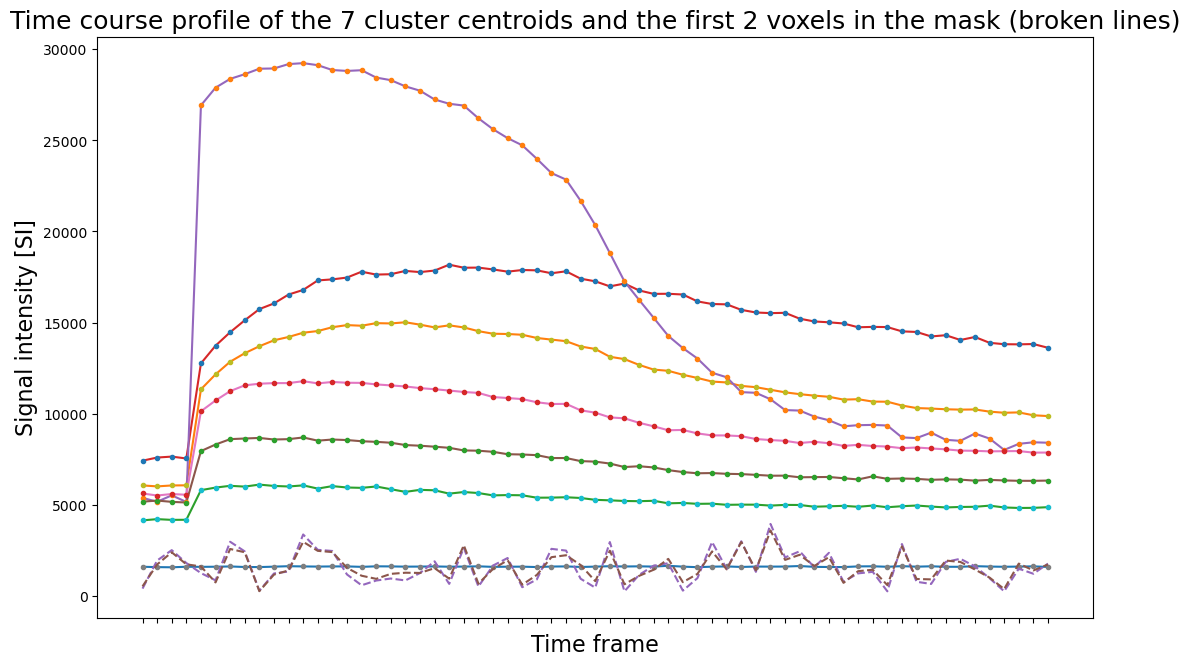

In [48]:
# Plot the cluster centroids as line plots

nv = 2

fig, ax = plt.subplots(1,1)

fig.set_size_inches(12, 7)

plt.plot(kmeans_fit.cluster_centers_.T)
plt.plot(kmeans_fit.cluster_centers_.T, '.')
plt.plot(X[:nv, :].T, '--')
plt.xlabel('Time frame', fontsize=16)
ax.set_xticks([x for x in range(X.shape[1])])
ax.set_xticklabels([], rotation='vertical', fontsize=18)
plt.ylabel('Signal intensity [SI]', fontsize=16)
#plt.xlim(0, 3)
plt.title('Time course profile of the %d cluster centroids and the first %d voxels in the mask (broken lines)' % (K, nv), fontsize=18)

plt.subplots_adjust(bottom=.12, top=.95, right=.95, left=.12)

plt.show()


**Make a k-means segmented image (segmentation restricted to the ROI)**

In [49]:
kmeans_segm2 = 0 * data_msk.copy()
print('Size of segmented image:', kmeans_segm2.shape)
print('min:', kmeans_fit.labels_.min())
print('max:', kmeans_fit.labels_.max())
print('Number of clustered samples within ROI:', len(ind_roi[0]))

Size of segmented image: (256, 256, 1)
min: 0
max: 6
Number of clustered samples within ROI: 65535


**Assign the cluster belonging to each voxel within the ROI**

In [50]:
for v in range(len(ind_roi[0])):
    kmeans_segm2[ind_roi[0][v], ind_roi[1][v], ind_roi[2][v]] = kmeans_fit.labels_[v]

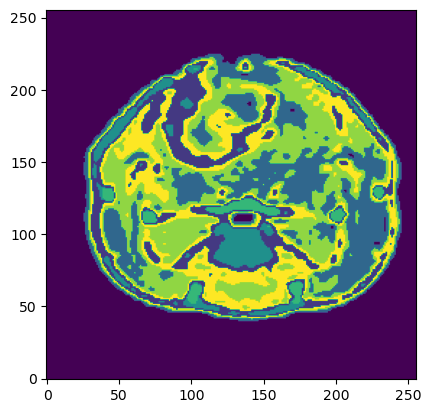

In [51]:
plt.imshow(np.fliplr(np.transpose(kmeans_segm2[:, :, s])), cmap='viridis', origin='lower')
plt.show()

In [52]:
f'./data/{id}_T1_DYN.nii.gz'

'./data/CBno20B_ng2_1and2_7_2_multispectral_T1_DYN.nii.gz'

In [53]:
#!freeview -v ./data/CBno20B_ng2_1and2_7_2_multispectral_T1_DYN.nii.gz